# Adversarial AutoEncoder for MNIST (with GPU implementation)

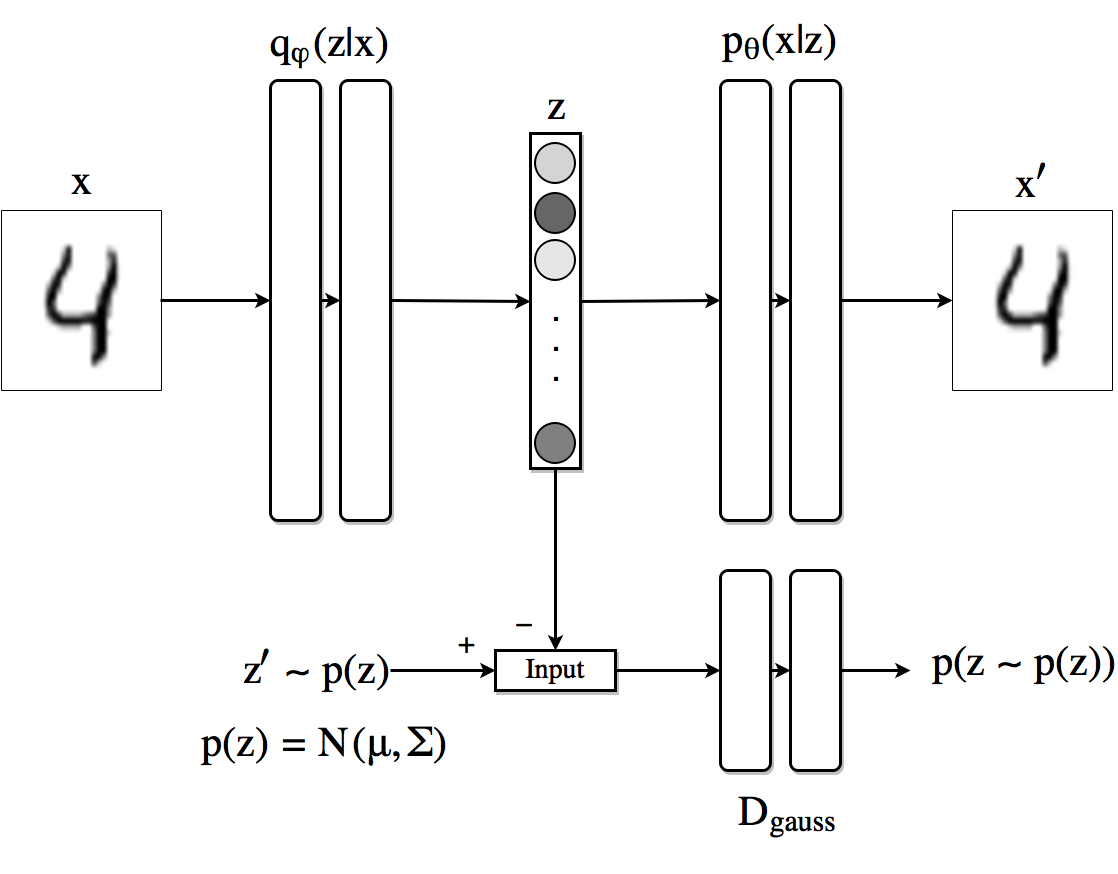
$$\text{Schematic of an AAE}$$

## Idea behind AAE:

* Very similar to VAEs. Howeve, instead of using KL divergence penalty to impose a prior distribution on the hidden code vector, one uses an adversarial training procedure to do so by matching the aggregated posterior $p(z)$ of the hidden code vectore with the prior distribution.

$$p(z) = \int q(z\vert x)p_d(x)dx$$

### Import necessary libraries

In [1]:
import os #will be used for creating directories, etc.

import torch
import torchvision.datasets as dsets             #for downloading dataset
import torchvision.transforms as transforms      #for transforming dataset into tensors

from torch import nn
import torchvision

from torch.autograd import Variable

from torch.nn import functional as F

from time import time

### Prepare MNIST dataset

In [2]:
#download MNIST dataset
dataset = dsets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)

### Utility functions

In [3]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def to_np(x):
    return x.data.cpu().numpy()

### Training parameters

In [4]:
batch_size = 100

# shuffle and prepare dataset with minibatches
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

### Create Autoencoder NN

In [5]:
# We are going to create three neural nets - Encoder, Decoder, and Adversarial

# Encoder
class ENC_net(nn.Module): 
    def __init__(self, X_dim, N, z_dim):
        super(ENC_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3gauss = nn.Linear(N, z_dim)
    
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = F.relu(x)
        xgauss = self.lin3gauss(x)
        return xgauss
    

# Decoder
class DEC_net(nn.Module):  
    def __init__(self, X_dim, N, z_dim):
        super(DEC_net, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, X_dim)
        
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = self.lin3(x)
        return F.sigmoid(x)
    
    
# Discriminator
class D_net_gauss(nn.Module):  
    def __init__(self, N, z_dim):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, 1)
        
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)
        return F.sigmoid(self.lin3(x))

In [6]:
# Create Autoencoder model
z_red_dims = 120

Q = ENC_net(784, 1000, z_red_dims)
P = DEC_net(784, 1000, z_red_dims)
D_gauss = D_net_gauss(500, z_red_dims)

if torch.cuda.is_available():
    Q.cuda()
    P.cuda()
    D_gauss.cuda()

### Optimizer

In [7]:
# Set learning rates
gen_lr = 0.0001
reg_lr = 0.00005

#encode/decode optimizers
optim_P = torch.optim.Adam(P.parameters(), lr=gen_lr)
optim_Q_enc = torch.optim.Adam(Q.parameters(), lr=gen_lr)

#regularizing optimizers
optim_Q_gen = torch.optim.Adam(Q.parameters(), lr=reg_lr)
optim_D = torch.optim.Adam(D_gauss.parameters(), lr=reg_lr)

### Let's train!!

In [8]:
EPS = 1e-15

# We want to go through all the examples in each epoch, so number of iterations per epoch
iter_per_epoch = len(data_loader)
data_iter      = iter(data_loader) # data_iter is an iterator object
total_step     = 50000

#### Now we want to view and save results on a fixed batch to visualize Autoencoder's performance

In [9]:
# save fixed inputs for debugging
fixed_x, _ = next(data_iter)        #points to the first batch
torchvision.utils.save_image(Variable(fixed_x).data.cpu(), './data/real_images.png')
fixed_x = to_var(fixed_x.view(fixed_x.size(0), -1))

### Begin training

In [10]:
# Start training
for step in range(total_step):
    
    # Reset the data_iter
    if (step+1) % iter_per_epoch == 0:
        data_iter = iter(data_loader)
        
    # Fetch the images and labels and convert them to variables
    images, labels = next(data_iter)
    images, labels = to_var(images.view(images.size(0), -1)), to_var(labels)
    
    # Reconstruction loss
    P.zero_grad()
    Q.zero_grad()
    D_gauss.zero_grad()
    
    z_sample   = Q(images)   # encode to z
    X_sample   = P(z_sample) # decode to X reconstruction
    recon_loss = F.binary_cross_entropy(X_sample+EPS, images+EPS)
    
    recon_loss.backward()
    optim_P.step()
    optim_Q_enc.step()
    
    # Discriminator
    ## true prior is random normal (randn)
    ## this is constraining the Z-projection to be normal!
    
    Q.eval()
    z_real_gauss = to_var(torch.randn(images.size()[0], z_red_dims) * 5.)
    D_real_gauss = D_gauss(z_real_gauss)
    
    z_fake_gauss = Q(images)
    D_fake_gauss = D_gauss(z_fake_gauss)
    
    D_loss = -torch.mean(torch.log(D_real_gauss + EPS) + torch.log(1 - D_fake_gauss + EPS))
    
    D_loss.backward()
    optim_D.step()
    
    # Generator
    Q.train()
    z_fake_gauss = Q(images)
    D_fake_gauss = D_gauss(z_fake_gauss)
    
    G_loss = -torch.mean(torch.log(D_fake_gauss + EPS))

    G_loss.backward()
    optim_Q_gen.step()
    
    if (step+1) % iter_per_epoch == 0:
        z_fixed        = Q(fixed_x)   # encode to z
        reconst_images = P(z_fixed)   # decode to X reconstruction
        reconst_images = reconst_images.view(reconst_images.size(0), 1, 28, 28)
        torchvision.utils.save_image(reconst_images.data.cpu(), './data/reconst_images_%d.png' % int((step+1)/iter_per_epoch))
        
        z_sample       = to_var(torch.randn(images.size()[0], z_red_dims) * 5.)
        sample_images  = P(z_sample)
        sample_images  = sample_images.view(sample_images.size(0), 1, 28, 28)
        torchvision.utils.save_image(sample_images.data.cpu(), './results/sample_images_%d.png' % int((step+1)/iter_per_epoch))

C:\Users\mayan\Anaconda3\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
